In [7]:
import matplotlib.pyplot as plt

# Windows: 'Malgun Gothic', Mac: 'AppleGothic', Colab: 'NanumGothic'
plt.rcParams['font.family'] = 'pretendard'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 깨짐 방지


In [2]:
import pyarrow.parquet as pq

# 먼저 parquet 파일의 컬럼 목록 확인
parquet_file = pq.ParquetFile("merged_승인매출정보.parquet")
전체컬럼 = parquet_file.schema.names

# 필요한 컬럼만 추출
필요컬럼 = [col for col in 전체컬럼 if ('_선결제' in col or '_연체' in col) or col == 'ID']

# 필요한 컬럼만 불러오기
승인매출정보 = pd.read_parquet("merged_승인매출정보.parquet", columns=필요컬럼)


In [4]:
# 회원정보는 ID, Segment만 로딩
회원정보 = pd.read_parquet("merged_회원정보.parquet", columns=['ID', 'Segment'])

# 고객별 평균값 집계
선결제_컬럼 = [col for col in 승인매출정보.columns if '_선결제' in col]
연체_컬럼   = [col for col in 승인매출정보.columns if '_연체' in col]

# ID 기준 평균 집계
선결제_고객 = 승인매출정보[['ID'] + 선결제_컬럼].groupby('ID').mean(numeric_only=True).reset_index()
연체_고객   = 승인매출정보[['ID'] + 연체_컬럼].groupby('ID').mean(numeric_only=True).reset_index()

# Segment 병합
선결제_고객 = pd.merge(선결제_고객, 회원정보, on='ID', how='left')
연체_고객   = pd.merge(연체_고객, 회원정보, on='ID', how='left')


In [5]:
# Segment별 평균값 계산
선결제_세그별 = 선결제_고객.groupby('Segment').mean(numeric_only=True).reset_index()
연체_세그별   = 연체_고객.groupby('Segment').mean(numeric_only=True).reset_index()

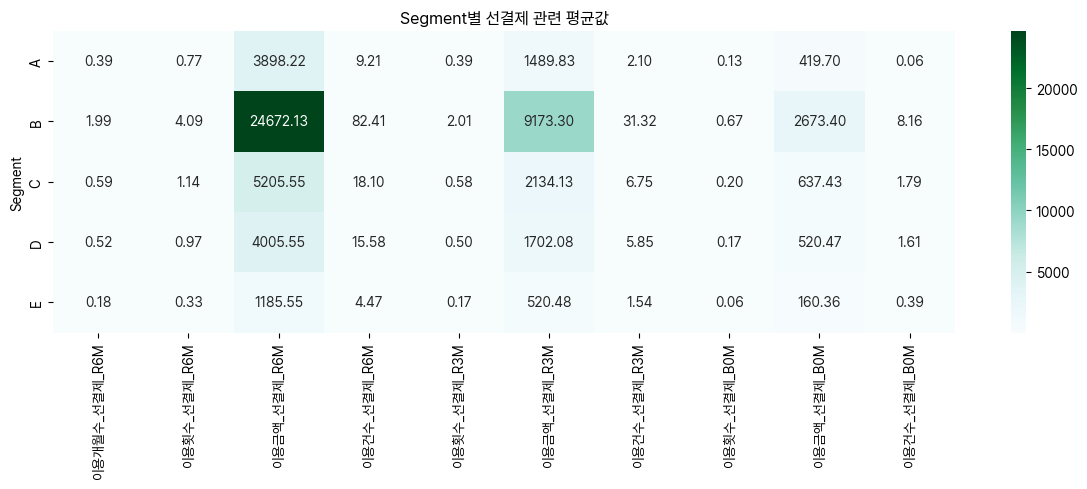

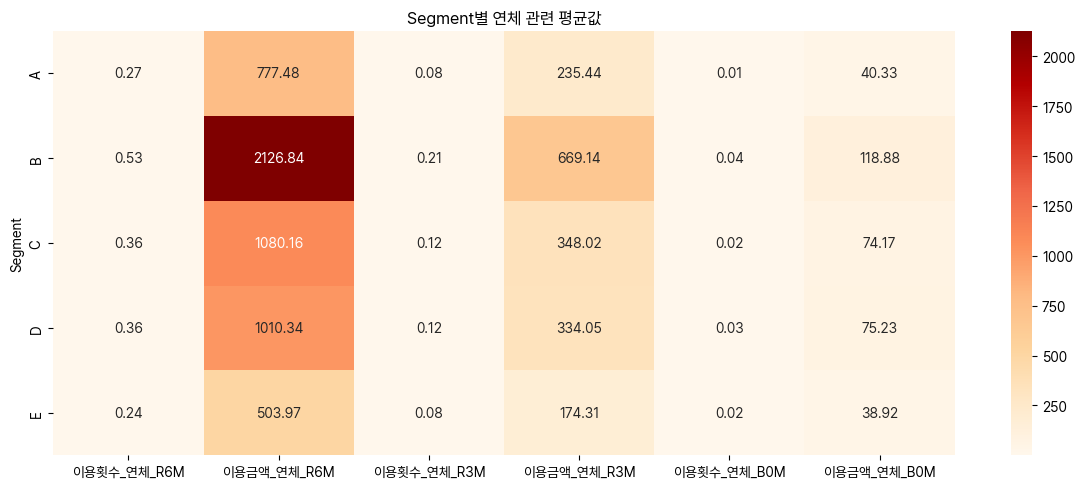

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 선결제 Heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(선결제_세그별.set_index('Segment'), annot=True, fmt=".2f", cmap='BuGn')
plt.title("Segment별 선결제 관련 평균값")
plt.tight_layout()
plt.show()

# 연체 Heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(연체_세그별.set_index('Segment'), annot=True, fmt=".2f", cmap='OrRd')
plt.title("Segment별 연체 관련 평균값")
plt.tight_layout()
plt.show()

In [9]:
import pyarrow.parquet as pq

# 승인매출정보 컬럼 목록 불러오기
parquet_file = pq.ParquetFile("merged_승인매출정보.parquet")
전체컬럼 = parquet_file.schema.names

# 키워드 기반 필터링
입금청구_컬럼 = [col for col in 전체컬럼
               if any(x in col for x in ['정상입금원금_', '연체입금원금_', '정상청구원금_', '선입금원금_'])]

# ID 포함
입금청구_컬럼 = ['ID'] + 입금청구_컬럼
print("선택된 컬럼 수:", len(입금청구_컬럼))

선택된 컬럼 수: 13


In [10]:
import pandas as pd

승인매출정보 = pd.read_parquet("merged_승인매출정보.parquet", columns=입금청구_컬럼)

In [11]:
# 고객별 평균값 계산
입금청구_고객 = 승인매출정보.groupby('ID').mean(numeric_only=True).reset_index()

# 회원정보에서 Segment 불러오기
회원정보 = pd.read_parquet("merged_회원정보.parquet", columns=['ID', 'Segment'])

# 병합
입금청구_고객 = pd.merge(입금청구_고객, 회원정보, on='ID', how='left')

In [12]:
세그먼트별_입금청구 = 입금청구_고객.groupby('Segment').mean(numeric_only=True).reset_index()

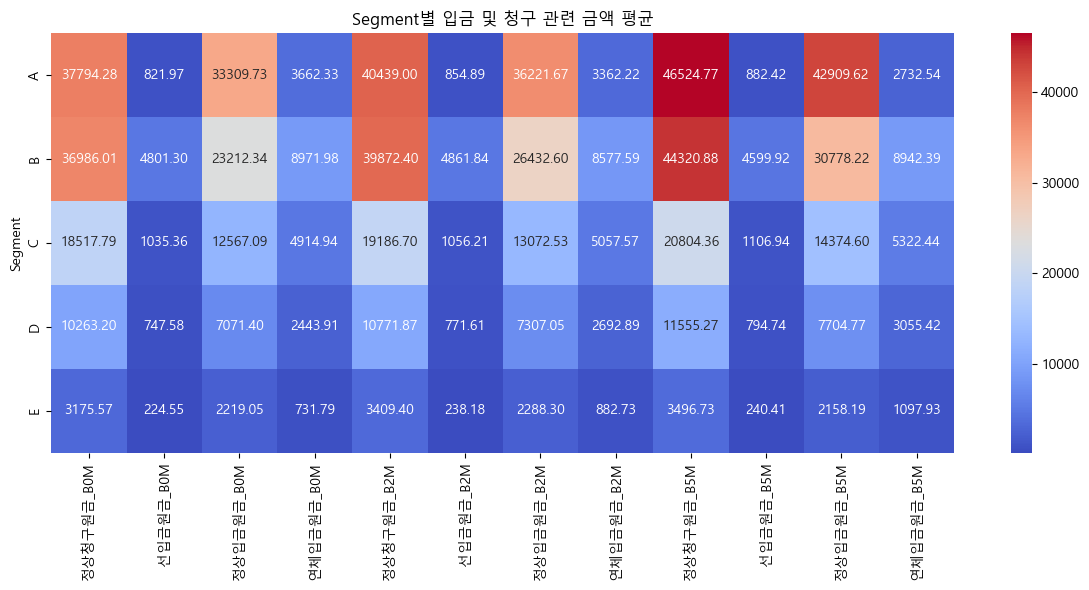

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
sns.heatmap(세그먼트별_입금청구.set_index('Segment'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Segment별 입금 및 청구 관련 금액 평균")
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

# 데이터 불러오기 (필요한 컬럼만 있는 parquet 파일)
승인매출정보 = pd.read_parquet("merged_승인매출정보.parquet")
회원정보 = pd.read_parquet("merged_회원정보.parquet")

# 1. 분석 대상 컬럼 추출
타겟_키워드 = ['선입금원금_', '정상입금원금_', '연체입금원금_', '정상청구원금_']
시점 = ['B0M', 'B2M', 'B5M']

# 2. 대상 컬럼명 필터링
타겟_컬럼 = [col for col in 승인매출정보.columns 
             if any(k in col for k in 타겟_키워드) and any(m in col for m in 시점)]

# 3. 고객 단위 평균 집계
고객단위 = 승인매출정보.groupby('ID')[타겟_컬럼].mean(numeric_only=True).reset_index()

# 4. Segment 병합
회원정보 = 회원정보[['ID', 'Segment']].drop_duplicates()
고객단위 = pd.merge(고객단위, 회원정보, on='ID', how='left')

# 5. Segment별 평균 집계
세그먼트별평균 = 고객단위.groupby('Segment')[타겟_컬럼].mean().reset_index()

# 6. 시점별 항목 분리 → long format 변환
세그먼트별평균_melted = pd.melt(
    세그먼트별평균,
    id_vars='Segment',
    var_name='항목',
    value_name='평균금액'
)

# 7. 항목 이름 → 종류, 시점 분리
세그먼트별평균_melted['종류'] = 세그먼트별평균_melted['항목'].apply(lambda x: x.split('_')[0])
세그먼트별평균_melted['시점'] = 세그먼트별평균_melted['항목'].apply(lambda x: x.split('_')[-1])

# 8. 피벗 테이블 구성
비교표 = 세그먼트별평균_melted.pivot_table(
    index=['Segment', '종류'],
    columns='시점',
    values='평균금액'
).reset_index()

# 9. 결과 확인
print(비교표.head())

시점 Segment      종류           B0M           B2M           B5M
0        A   선입금원금    821.967078    854.886831    882.415638
1        A  연체입금원금   3662.334362   3362.217078   2732.540123
2        A  정상입금원금  33309.734568  36221.668724  42909.624486
3        A  정상청구원금  37794.282922  40439.004115  46524.772634
4        B   선입금원금   4801.298611   4861.840278   4599.916667


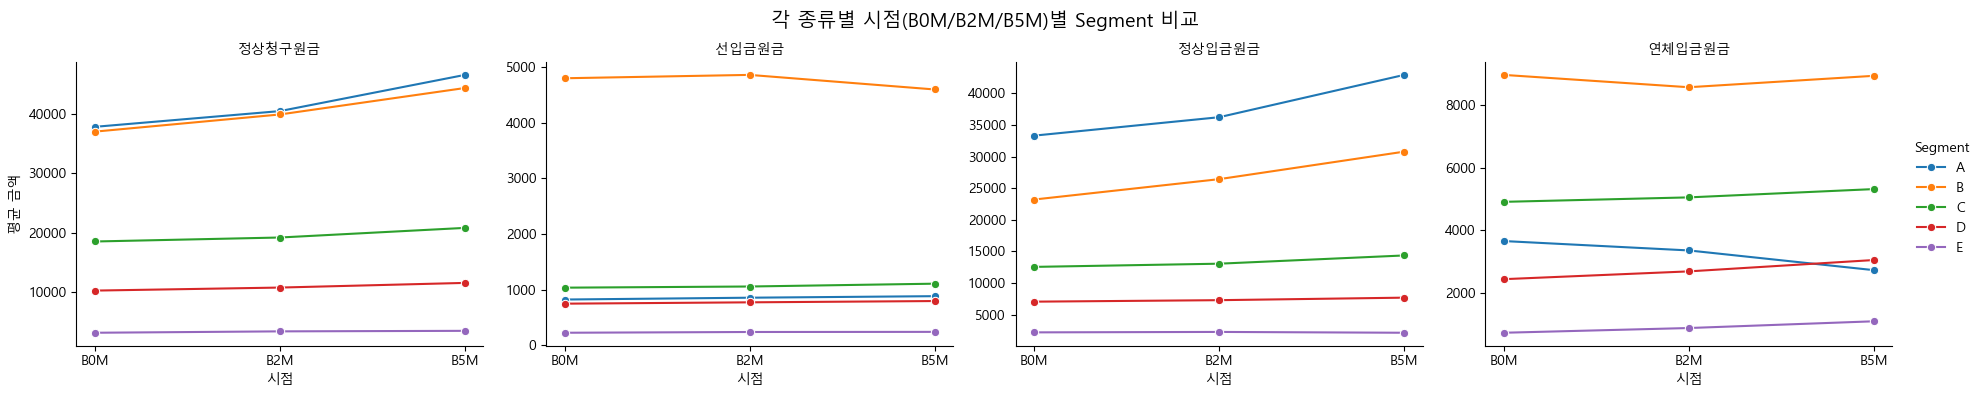

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 폰트 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ melt된 데이터가 있어야 함: 세그먼트별평균_melted (컬럼: Segment, 항목, 평균금액, 종류, 시점)

# ✅ 시각화: 종류별로 분리하여 시점별 평균금액을 Segment별로 비교
g = sns.FacetGrid(
    세그먼트별평균_melted,
    col="종류",      # 선입금원금 / 연체입금원금 등
    hue="Segment",   # A~E 세그먼트
    sharey=False,
    height=4,
    aspect=1.2
)
g.map(sns.lineplot, "시점", "평균금액", marker="o")
g.add_legend()
g.set_titles("{col_name}")
g.set_axis_labels("시점", "평균 금액")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("각 종류별 시점(B0M/B2M/B5M)별 Segment 비교", fontsize=14)
plt.show()